In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, optimizers, Input, optimizers
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from time import sleep
from sklearn.preprocessing import StandardScaler
import time
import pprint
tf.__version__

'2.8.0'

In [2]:
len(tf.config.list_physical_devices('GPU'))>0

False

In [3]:
device_name = tf.test.gpu_device_name()
print(device_name)

In [4]:
X_x_train = np.loadtxt("./data/X_x_train.txt")
X_y_train = np.loadtxt("./data/X_y_train.txt")
X_z_train = np.loadtxt("./data/X_z_train.txt")
y_train = np.loadtxt("./data/y_train.txt")

X_x_test = np.loadtxt("./data/X_x_train.txt")
X_y_test = np.loadtxt("./data/X_y_train.txt")
X_z_test = np.loadtxt("./data/X_z_train.txt")
y_test = np.loadtxt("./data/y_train.txt")

In [5]:
# for i, r in tqdm(X_x_train[:], total=X_x_train.shape[0], desc="printing graphs..."):
#     print("plot" +str(i))
#     row = X_x_train[i,:-1]
#     y = X_x_train[i,-1:]
#     print(label_names[int(y)-1])
#     plt.plot(row)
#     plt.show()


In [6]:
def standard_score_normalization(x):
    x_m = np.mean(x, axis=1).reshape(-1,1)
    x_std = np.std(x,axis=1).reshape(-1,1)
    return (x-x_m)/x_std

In [7]:
norm = StandardScaler()

In [8]:
X_x_train_norm = norm.fit_transform(X_x_train)
X_y_train_norm = norm.fit_transform(X_y_train)
X_z_train_norm = norm.fit_transform(X_y_train)

X_x_test_norm = norm.fit_transform(X_x_test)
X_y_test_norm = norm.fit_transform(X_y_test)
X_z_test_norm = norm.fit_transform(X_z_test)

### Below I'm comparing two different concatenation functions.

concat_xyz is vectorizing calculations while concat2_xyz is iterating

In [9]:
def concat_xyz(x,y,z):
    data = np.empty((x.shape[0],x.shape[1],3))
#     x = np.expand_dims(x, axis=1) # same as x = x[:,np.newaxis,:]
#     y = np.expand_dims(y, axis=1)
#     z = np.expand_dims(z, axis=1)
    data[:,:,0] = x
    data[:,:,1] = y
    data[:,:,2] = z
    return data

In [10]:
#speed test purposes
def concat2_xyz(x,y,z):
    data = np.empty((x.shape[0],x.shape[1],3))
    for i, rowx,rowy, rowz in zip(range(x.shape[0]),x,y,z):
        data[i,:,0] = rowx.reshape(1,-1)
        data[i,:,1] = rowy.reshape(1,-1)
        data[i,:,2] = rowz.reshape(1,-1)
    return data

In [11]:
tic = time.perf_counter()
X_xyz_norm_train =  concat_xyz(X_x_train_norm,X_y_train_norm, X_z_train_norm)
X_xyz_norm_test = concat_xyz(X_x_test_norm,X_y_test_norm,X_z_test_norm)
toc = time.perf_counter()
print(f"concat_xyz in {toc - tic:0.4f} seconds")

concat_xyz in 0.0110 seconds


In [12]:
#speed test purposes
tic = time.perf_counter()
concat2_xyz(X_x_train_norm,X_y_train_norm, X_z_train_norm)
concat_xyz(X_x_test_norm,X_y_test_norm,X_z_test_norm)
toc = time.perf_counter()
print(f"concat2_xyz in {toc - tic:0.4f} seconds")

concat2_xyz in 0.0192 seconds


#### Vectorizing calculations is faster


In [13]:
label_names = ['Walking', 'Walking upstairs', 'Walking downstairs', 'Sitting', 'Standing', 'Laying']
num_outputs = len(label_names)

In [14]:
# one hot encoding

y_train = np.eye(len(label_names))[(y_train-1).astype(int)]
y_test = np.eye(len(label_names))[(y_train-1).astype(int)]

In [15]:
X_xyz_norm_train.shape

(7352, 128, 3)

In [16]:
input_shape = X_xyz_norm_train.shape[1:]

In TF1 placeholder would be needed to get shape of `(None, 128, 3)` but here we take `(128, 3)` as input shape instead

<H1>Implementing CNN</H1>

In [17]:
cnn = models.Sequential()
cnn.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
# cnn.add(layers.MaxPool1D(pool_size=2))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(100, activation='relu'))
cnn.add(layers.Dense(30, activation='relu'))
cnn.add(layers.Dense(num_outputs,activation='softmax'))

In [18]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 127, 64)           448       
                                                                 
 flatten (Flatten)           (None, 8128)              0         
                                                                 
 dense (Dense)               (None, 100)               812900    
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 6)                 186       
                                                                 
Total params: 816,564
Trainable params: 816,564
Non-trainable params: 0
_________________________________________________________________


In [19]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
cnn.compile(optimizer="adam",
           loss="categorical_crossentropy",
           metrics="accuracy")

In [23]:
cnnhistory = cnn.fit(X_xyz_norm_train, y_train, epochs=30, batch_size = 10)

Epoch 1/30
736/736 [==============================] - 2s 2ms/step - loss: 0.9479 - accuracy: 0.5339
Epoch 2/30
736/736 [==============================] - 2s 2ms/step - loss: 0.6816 - accuracy: 0.6325
Epoch 3/30
736/736 [==============================] - 2s 2ms/step - loss: 0.6311 - accuracy: 0.6737
Epoch 4/30
736/736 [==============================] - 2s 2ms/step - loss: 0.5728 - accuracy: 0.7220
Epoch 5/30
736/736 [==============================] - 2s 2ms/step - loss: 0.5191 - accuracy: 0.7603
Epoch 6/30
736/736 [==============================] - 2s 2ms/step - loss: 0.4850 - accuracy: 0.7720
Epoch 7/30
736/736 [==============================] - 2s 2ms/step - loss: 0.4562 - accuracy: 0.7866
Epoch 8/30
736/736 [==============================] - 2s 2ms/step - loss: 0.4547 - accuracy: 0.7942
Epoch 9/30
736/736 [==============================] - 2s 2ms/step - loss: 0.4329 - accuracy: 0.8048
Epoch 10/30
736/736 [==============================] - 2s 2ms/step - loss: 0.4142 - accuracy: 0.8181

In [24]:
# cnn.save("my_model")
# tensorflow_graph = tf.saved_model.load("my_model")
# x = np.random.uniform(size=(4, 32)).astype(np.float32)
# predicted = tensorflow_graph(x).numpy()

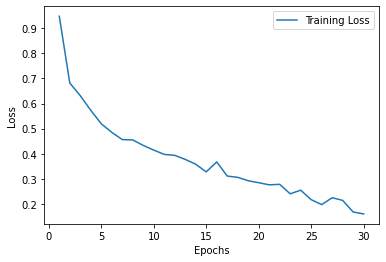

In [25]:
loss_values = cnnhistory.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

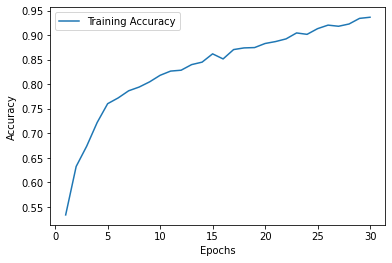

In [26]:
acc_values = cnnhistory.history['accuracy']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, acc_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
y_test_pred = cnn.predict(X_xyz_norm_test)
pprint.pprint(y_test_pred)
pprint.pprint(y_test)

array([[2.6025677e-05, 6.4557767e-05, 5.2852818e-07, 1.3772850e-01,
        8.0242372e-01, 5.9756737e-02],
       [3.7876525e-05, 3.9204540e-05, 7.1118319e-07, 4.6961582e-01,
        5.1498961e-01, 1.5316817e-02],
       [1.8401982e-04, 1.1497659e-04, 3.3713345e-06, 3.4160495e-02,
        9.5804244e-01, 7.4947923e-03],
       ...,
       [1.6142330e-13, 1.0000000e+00, 3.4971194e-08, 1.0317560e-21,
        6.5041261e-37, 2.4784678e-26],
       [1.1941105e-13, 1.0000000e+00, 9.4783494e-11, 6.2027886e-26,
        0.0000000e+00, 2.5504682e-27],
       [4.5512552e-13, 9.0587682e-01, 9.4123140e-02, 3.8493852e-16,
        0.0000000e+00, 3.7063656e-25]], dtype=float32)
array([[[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0

In [35]:
# tf.math.confusion_matrix(y_test,yhat)

<H1>Implementing LSTM</H1>

In [29]:
# LSTM

lstm = models.Sequential()
lstm.add(layers.Bidirectional(
    layers.LSTM(128),input_shape=input_shape
))

lstm.add(layers.Dropout(rate=0.2))
lstm.add(layers.Dense(6,activation="softmax"))



In [30]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              135168    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 136,710
Trainable params: 136,710
Non-trainable params: 0
_________________________________________________________________


In [31]:
lstm.compile(optimizer = "adam",
            loss="categorical_crossentropy",
            metrics = "accuracy"
            )

In [32]:
lstmhistory = lstm.fit(X_xyz_norm_train,y_train,epochs = 30,batch_size=10)

Epoch 1/30
736/736 [==============================] - 15s 19ms/step - loss: 1.0118 - accuracy: 0.4661
Epoch 2/30
736/736 [==============================] - 14s 19ms/step - loss: 0.9135 - accuracy: 0.5092
Epoch 3/30
736/736 [==============================] - 14s 19ms/step - loss: 0.8641 - accuracy: 0.5486
Epoch 4/30
736/736 [==============================] - 14s 19ms/step - loss: 0.8286 - accuracy: 0.5665
Epoch 5/30
736/736 [==============================] - 14s 19ms/step - loss: 0.8472 - accuracy: 0.5579
Epoch 6/30
736/736 [==============================] - 14s 19ms/step - loss: 0.7183 - accuracy: 0.6057
Epoch 7/30
736/736 [==============================] - 14s 19ms/step - loss: 0.6648 - accuracy: 0.6186
Epoch 8/30
736/736 [==============================] - 14s 19ms/step - loss: 0.6537 - accuracy: 0.6215
Epoch 9/30
736/736 [==============================] - 14s 19ms/step - loss: 0.6584 - accuracy: 0.6243
Epoch 10/30
736/736 [==============================] - 14s 19ms/step - loss: 0.651

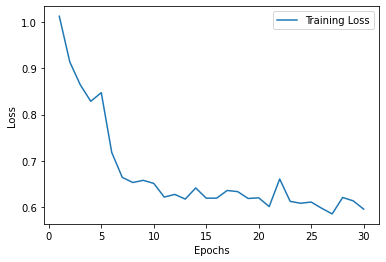

In [33]:
loss_values = lstmhistory.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

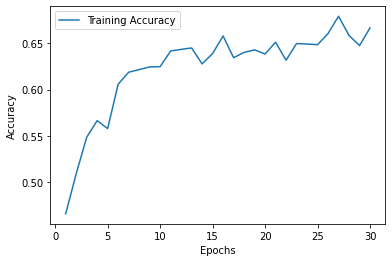

In [34]:
acc_values = lstmhistory.history['accuracy']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, acc_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()